<a href="https://colab.research.google.com/github/HoCogThanh/thanh/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import random
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from collections import Counter
import seaborn as sns


'/content/drive/MyDrive/DATASET/Lua' l√† m·ªôt th∆∞ m·ª•c h·ª£p l·ªá.

T·ªïng s·ªë l∆∞·ª£ng ·∫£nh trong to√†n b·ªô d·ªØ li·ªáu: 8736


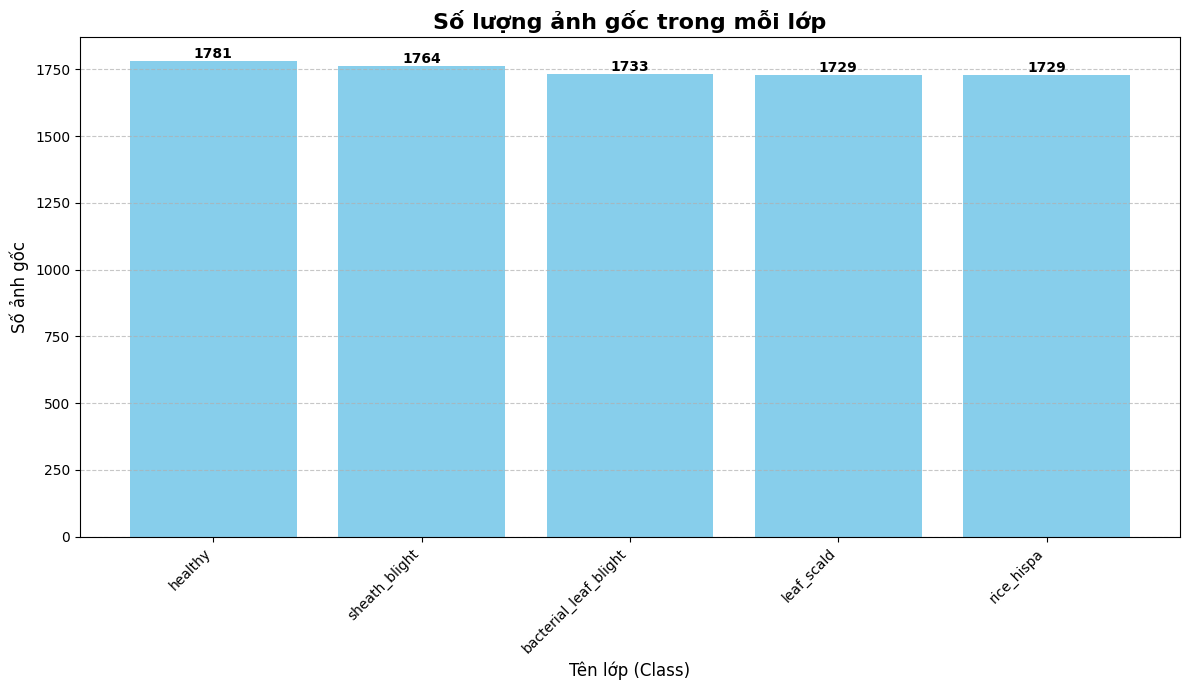

In [3]:
import os
import matplotlib.pyplot as plt

# --- Ki·ªÉm tra ƒë∆∞·ªùng d·∫´n v√† l·∫•y d·ªØ li·ªáu ---
data_dir = "/content/drive/MyDrive/DATASET/Lua"

if not os.path.isdir(data_dir):
    print(f"L·ªói: '{data_dir}' kh√¥ng ph·∫£i l√† m·ªôt th∆∞ m·ª•c h·ª£p l·ªá ho·∫∑c kh√¥ng t·ªìn t·∫°i.")
    # C√≥ th·ªÉ exit() ho·∫∑c return ·ªü ƒë√¢y n·∫øu mu·ªën d·ª´ng ch∆∞∆°ng tr√¨nh
else:
    print(f"'{data_dir}' l√† m·ªôt th∆∞ m·ª•c h·ª£p l·ªá.")

    # L·∫•y danh s√°ch c√°c l·ªõp (th∆∞ m·ª•c con)
    categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

    if not categories:
        print(f"Kh√¥ng t√¨m th·∫•y th∆∞ m·ª•c l·ªõp n√†o trong '{data_dir}'.")
    else:
        # Th·ªëng k√™ s·ªë l∆∞·ª£ng ·∫£nh trong m·ªói l·ªõp
        original_counts = {}
        supported_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff') # Th√™m c√°c ƒë·ªãnh d·∫°ng ·∫£nh ph·ªï bi·∫øn kh√°c

        for category in categories:
            class_path = os.path.join(data_dir, category)
            # L·ªçc c√°c file c√≥ ph·∫ßn m·ªü r·ªông ·∫£nh h·ª£p l·ªá
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith(supported_extensions) and os.path.isfile(os.path.join(class_path, f))]
            original_counts[category] = len(image_files)

        # --- In ra t·ªïng s·ªë ·∫£nh ---
        total_images = sum(original_counts.values())
        print(f"\nT·ªïng s·ªë l∆∞·ª£ng ·∫£nh trong to√†n b·ªô d·ªØ li·ªáu: {total_images}")

        # --- V·∫Ω bi·ªÉu ƒë·ªì s·ªë l∆∞·ª£ng ·∫£nh g·ªëc ---
        plt.figure(figsize=(12, 7)) # TƒÉng k√≠ch th∆∞·ªõc bi·ªÉu ƒë·ªì ƒë·ªÉ d·ªÖ nh√¨n h∆°n

        # S·∫Øp x·∫øp c√°c l·ªõp theo s·ªë l∆∞·ª£ng ·∫£nh ƒë·ªÉ bi·ªÉu ƒë·ªì d·ªÖ ƒë·ªçc h∆°n (t√πy ch·ªçn)
        sorted_counts = dict(sorted(original_counts.items(), key=lambda item: item[1], reverse=True))

        bars = plt.bar(sorted_counts.keys(), sorted_counts.values(), color='skyblue') # ƒê·ªïi m√†u cho d·ªÖ nh√¨n

        plt.title("S·ªë l∆∞·ª£ng ·∫£nh g·ªëc trong m·ªói l·ªõp", fontsize=16, fontweight='bold')
        plt.xlabel("T√™n l·ªõp (Class)", fontsize=12)
        plt.ylabel("S·ªë ·∫£nh g·ªëc", fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nh√£n v√† cƒÉn ch·ªânh
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Ghi s·ªë l∆∞·ª£ng l√™n c·ªôt
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, str(height), # ƒê·∫∑t text ngay tr√™n c·ªôt
                     ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

        plt.tight_layout() # T·ª± ƒë·ªông ƒëi·ªÅu ch·ªânh b·ªë c·ª•c ƒë·ªÉ tr√°nh ch·ªìng l·∫•n
        plt.show()

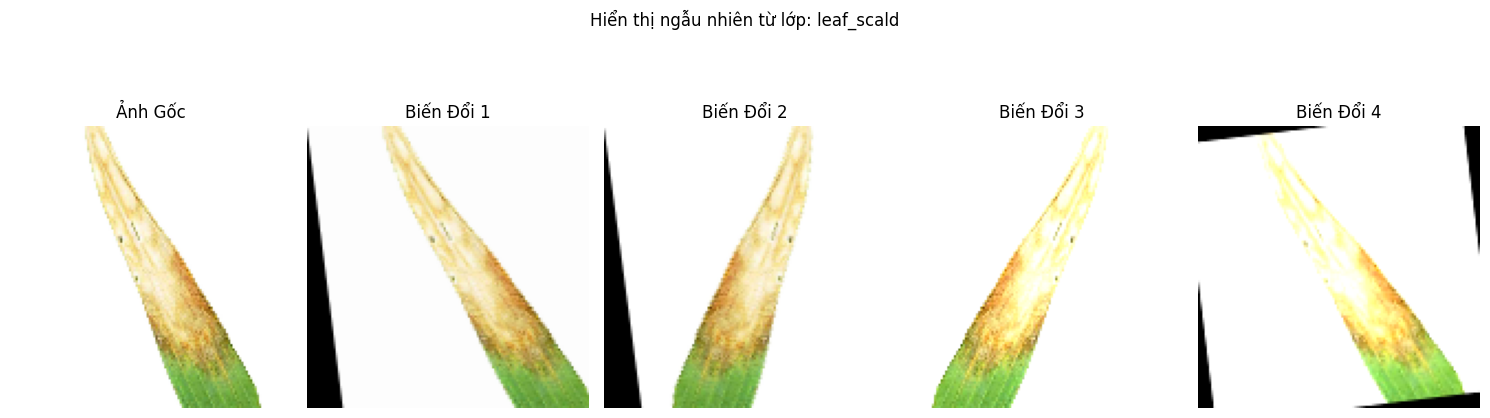


 ƒê√£ c√≥ ƒë·ªß 22 batch. B·∫Øt ƒë·∫ßu chu·∫©n h√≥a v√† chia t·∫≠p d·ªØ li·ªáu...

 T·ªïng s·ªë m·∫´u: 43680

 ƒê√£ l∆∞u scaler v√†o file scaler.pkl.

‚úÖ ƒê√£ l∆∞u train/val/test l·∫ßn 7 th√†nh c√¥ng!

 ƒê√£ chu·∫©n h√≥a, chia v√† l∆∞u train/val/test th√†nh c√¥ng!


In [ ]:

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# ==== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n v√† th√¥ng tin ====
data_dir = "/content/drive/MyDrive/DATASET/Lua"
dest_dir = '/content/drive/MyDrive/Lua _5_4Au_16.4'
processed_log_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/processed_images_lua.txt"

batch_size = 2000
X_batch, y_batch = [], []

# ==== Danh s√°ch l·ªõp ====
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
# ==== ƒê·∫£m b·∫£o th∆∞ m·ª•c t·ªìn t·∫°i ====
os.makedirs(dest_dir, exist_ok=True)

# ==== C√°c h√†m augmentation ====
def rotate_image(img):
    angle = random.randint(-20, 20)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

def flip_image(img):
    return cv2.flip(img, 1)

def shear_image(img):
    shear = random.uniform(-0.2, 0.2)
    M = np.array([[1, shear, 0],
                  [0,    1, 0]], dtype=np.float32)
    (h, w) = img.shape[:2]
    return cv2.warpAffine(img, M, (w, h))

def adjust_brightness(img):
    factor = random.uniform(0.7, 1.3)
    return np.clip(img * factor, 0, 255).astype(np.uint8)

def augment_image(img, n_augments=4):
    images = [img]
    for _ in range(n_augments):
        aug_img = img.copy()
        if random.random() < 0.5: aug_img = rotate_image(aug_img)
        if random.random() < 0.5: aug_img = flip_image(aug_img)
        if random.random() < 0.5: aug_img = shear_image(aug_img)
        if random.random() < 0.5: aug_img = adjust_brightness(aug_img)
        images.append(aug_img)
    return images

# ==== Hi·ªÉn th·ªã ·∫£nh m·∫´u ====
random_category = random.choice(categories)
random_class_path = os.path.join(data_dir, random_category)
random_image_name = random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

sample_img = cv2.imread(random_image_path)
if sample_img is not None:
    sample_img = cv2.resize(sample_img, (128, 128))
    sample_augmented_images = augment_image(sample_img)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    axes[0].imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("·∫¢nh G·ªëc")
    axes[0].axis('off')

    for i, aug_img in enumerate(sample_augmented_images[1:5]):
        axes[i+1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
        axes[i+1].set_title(f"Bi·∫øn ƒê·ªïi {i+1}")
        axes[i+1].axis('off')

    plt.suptitle(f"Hi·ªÉn th·ªã ng·∫´u nhi√™n t·ª´ l·ªõp: {random_category}")
    plt.tight_layout()
    plt.show()

# ==== Ki·ªÉm tra batch ƒë√£ t·ªìn t·∫°i ====
batch_files = sorted([
    f for f in os.listdir(dest_dir)
    if f.startswith("hog_batch_") and f.endswith(".npz")  # <<< CH·ªà hog_batch_, kh√¥ng "scaled"
])
existing_batches = sorted([
    int(f.split("_")[-1].split(".")[0])
    for f in batch_files
])
# T√≠nh s·ªë ·∫£nh g·ªëc
total_original_images = sum(len(os.listdir(os.path.join(data_dir, c))) for c in categories)

# M·ªói ·∫£nh t·∫°o ra 5 ·∫£nh (g·ªëc + 4 augment)
total_augmented_images = total_original_images * 5

# T√≠nh s·ªë batch c·∫ßn thi·∫øt
expected_batches = int(np.ceil(total_augmented_images / batch_size))

# ==== N·∫øu ƒë·ªß batch th√¨ chu·∫©n h√≥a to√†n b·ªô v√† chia ====
if len(batch_files) == expected_batches:
    print(f"\n ƒê√£ c√≥ ƒë·ªß {len(batch_files)} batch. B·∫Øt ƒë·∫ßu chu·∫©n h√≥a v√† chia t·∫≠p d·ªØ li·ªáu...")

    # Load to√†n b·ªô batch
    X_all = np.concatenate([
        np.load(os.path.join(dest_dir, f))['X'] for f in batch_files
    ], axis=0)
    y_all = np.concatenate([
        np.load(os.path.join(dest_dir, f))['y'] for f in batch_files
    ], axis=0)

    print(f"\n T·ªïng s·ªë m·∫´u: {X_all.shape[0]}")

    # Chu·∫©n h√≥a to√†n b·ªô
    #scaler = StandardScaler()
    scaler = MinMaxScaler()

    X_all_scaled = scaler.fit_transform(X_all)
    joblib.dump(scaler, os.path.join(dest_dir, "scaler.pkl"))
    print("\n ƒê√£ l∆∞u scaler v√†o file scaler.pkl.")

    # Chia train/val/test
    #X_train, X_temp, y_train, y_temp = train_test_split(X_all_scaled, y_all, test_size=0.2, stratify=y_all, random_state=42)
    #X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    X_train, X_temp, y_train, y_temp = train_test_split(X_all_scaled, y_all, test_size=0.3, stratify=y_all)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)
    train_round = 1
    while os.path.exists(os.path.join(dest_dir, f"X_train{train_round}.npy")):
         train_round += 1
    np.save(os.path.join(dest_dir, f"X_train{train_round}.npy"), X_train)
    np.save(os.path.join(dest_dir, f"X_val{train_round}.npy"), X_val)
    np.save(os.path.join(dest_dir, f"X_test{train_round}.npy"), X_test)
    np.save(os.path.join(dest_dir, f"y_train{train_round}.npy"), y_train)
    np.save(os.path.join(dest_dir, f"y_val{train_round}.npy"), y_val)
    np.save(os.path.join(dest_dir, f"y_test{train_round}.npy"), y_test)

    print(f"\n‚úÖ ƒê√£ l∆∞u train/val/test l·∫ßn {train_round} th√†nh c√¥ng!")

    #np.save(os.path.join(dest_dir, "X_train.npy"), X_train)
    #np.save(os.path.join(dest_dir, "X_val.npy"), X_val)
    #np.save(os.path.join(dest_dir, "X_test.npy"), X_test)
    #np.save(os.path.join(dest_dir, "y_train.npy"), y_train)
    #np.save(os.path.join(dest_dir, "y_val.npy"), y_val)
    #np.save(os.path.join(dest_dir, "y_test.npy"), y_test)

    print("\n ƒê√£ chu·∫©n h√≥a, chia v√† l∆∞u train/val/test th√†nh c√¥ng!")

# ==== N·∫øu ch∆∞a ƒë·ªß batch th√¨ ti·∫øp t·ª•c tr√≠ch xu·∫•t ====
else:
    print(f"\n M·ªõi c√≥ {len(batch_files)} batch. C·∫ßn {expected_batches} batch ƒë·ªÉ x·ª≠ l√Ω.")
    if existing_batches:
        last_batch = max(existing_batches)
        batch_counter = last_batch + 1
        samples_done = len(existing_batches) * batch_size
        print(f" Ti·∫øp t·ª•c t·ª´ batch {batch_counter} (ƒë√£ c√≥ {len(existing_batches)} batch)")
    else:
        batch_counter = 0
        samples_done = 0

    samples_processed = 0

    if os.path.exists(processed_log_path):
        with open(processed_log_path, "r") as f:
            processed_images = set(line.strip() for line in f)
    else:
        processed_images = set()

    for idx, category in enumerate(categories):
        class_path = os.path.join(data_dir, category)
        for img_name in os.listdir(class_path):
            image_id = f"{category}/{img_name}"
            if image_id in processed_images:
                continue

            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            img = cv2.resize(img, (128, 128))
            augmented_images = augment_image(img)

            if samples_processed < samples_done:
                samples_processed += len(augmented_images)
                continue

            for aug_img in augmented_images:
                gray = cv2.cvtColor(aug_img, cv2.COLOR_BGR2GRAY)
                '''
                hog_features, _ = hog(
                    gray, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4),
                    feature_vector=True,
                    visualize=True
                )
                '''
                hog_features = hog(
                    gray,
                    pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4),
                    feature_vector=True,
                    visualize=False # S·ª≠a l·ªói: Kh√¥ng c·∫ßn visualize n·∫øu kh√¥ng s·ª≠ d·ª•ng
                )
                X_batch.append(hog_features)
                y_batch.append(idx)

                if len(X_batch) >= batch_size:
                    np.savez_compressed(os.path.join(dest_dir, f"hog_batch_{batch_counter}.npz"), X=np.array(X_batch), y=np.array(y_batch))
                    print(f" ƒê√£ l∆∞u batch {batch_counter} (ch∆∞a chu·∫©n h√≥a) v·ªõi {len(X_batch)} m·∫´u")
                    X_batch, y_batch = [], []
                    batch_counter += 1

            processed_images.add(image_id)
            with open(processed_log_path, "a") as f:
                f.write(image_id + "\n")

    if X_batch:
        np.savez_compressed(os.path.join(dest_dir, f"hog_batch_{batch_counter}.npz"), X=np.array(X_batch), y=np.array(y_batch))
        print(f" ƒê√£ l∆∞u batch cu·ªëi {batch_counter} (ch∆∞a chu·∫©n h√≥a) v·ªõi {len(X_batch)} m·∫´u")



===== Tr·ª±c Quan H√≥a ·∫¢nh M·∫´u v√† ƒê·∫∑c Tr∆∞ng HOG =====

S·ªë l∆∞·ª£ng ƒë·∫∑c tr∆∞ng HOG tr√≠ch xu·∫•t: 3600


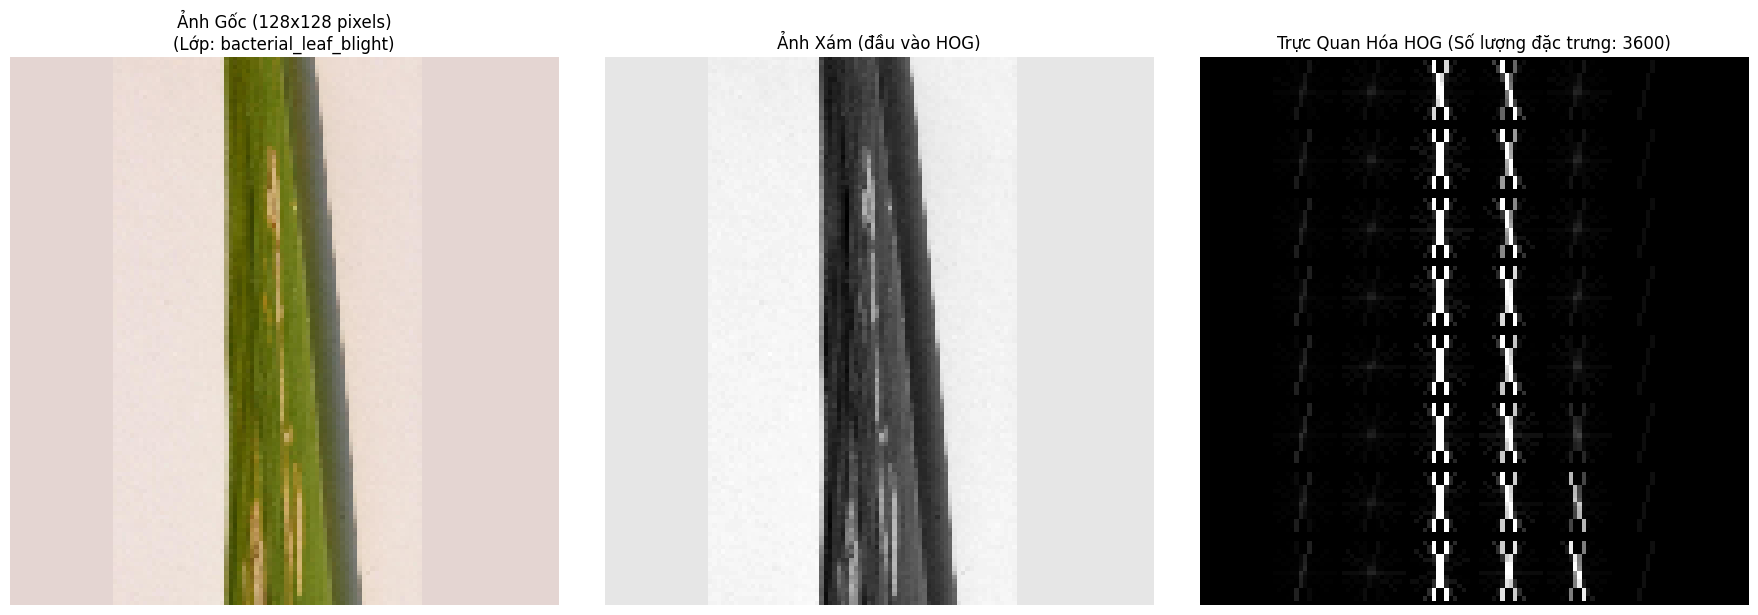

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure # ƒê·ªÉ tƒÉng c∆∞·ªùng ƒë·ªô t∆∞∆°ng ph·∫£n c·ªßa ·∫£nh HOG

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n v√† th√¥ng tin (ƒë·∫£m b·∫£o tr√πng v·ªõi code g·ªëc) ======
DATA_DIR = "/content/drive/MyDrive/DATASET/Lua" # Th∆∞ m·ª•c ch·ª©a ·∫£nh g·ªëc
# C√°c categories c·∫ßn ph·∫£i gi·ªëng h·ªát nh∆∞ trong code x·ª≠ l√Ω d·ªØ li·ªáu c·ªßa b·∫°n
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# K√≠ch th∆∞·ªõc ·∫£nh ƒë·∫ßu v√†o cho HOG (c≈©ng ph·∫£i gi·ªëng v·ªõi code x·ª≠ l√Ω)
HOG_IMAGE_SIZE = (128, 128)

# Tham s·ªë HOG (c≈©ng ph·∫£i gi·ªëng v·ªõi code x·ª≠ l√Ω)
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (4, 4)

# ====== Ch·ªçn m·ªôt ·∫£nh m·∫´u ng·∫´u nhi√™n ƒë·ªÉ tr·ª±c quan h√≥a ======
print("\n===== Tr·ª±c Quan H√≥a ·∫¢nh M·∫´u v√† ƒê·∫∑c Tr∆∞ng HOG =====")

# Ch·ªçn ng·∫´u nhi√™n m·ªôt l·ªõp v√† m·ªôt ·∫£nh
random_category_name = np.random.choice(categories)
random_class_path = os.path.join(DATA_DIR, random_category_name)

# ƒê·∫£m b·∫£o th∆∞ m·ª•c l·ªõp kh√¥ng r·ªóng
if not os.listdir(random_class_path):
    print(f"L·ªói: Th∆∞ m·ª•c '{random_class_path}' tr·ªëng. Kh√¥ng th·ªÉ ch·ªçn ·∫£nh m·∫´u.")
    exit()

random_image_name = np.random.choice(os.listdir(random_class_path))
random_image_path = os.path.join(random_class_path, random_image_name)

# ƒê·ªçc ·∫£nh
sample_img = cv2.imread(random_image_path)

if sample_img is None:
    print(f"L·ªói: Kh√¥ng th·ªÉ ƒë·ªçc ·∫£nh t·ª´ ƒë∆∞·ªùng d·∫´n: {random_image_path}")
else:
    # Chuy·ªÉn ƒë·ªïi ·∫£nh sang kh√¥ng gian m√†u RGB ƒë·ªÉ hi·ªÉn th·ªã ƒë√∫ng
    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

    # Resize ·∫£nh v·ªÅ k√≠ch th∆∞·ªõc chu·∫©n
    sample_img_resized = cv2.resize(sample_img_rgb, HOG_IMAGE_SIZE)

    # Chuy·ªÉn ƒë·ªïi ·∫£nh sang ·∫£nh x√°m ƒë·ªÉ t√≠nh HOG
    sample_img_gray = cv2.cvtColor(sample_img_resized, cv2.COLOR_RGB2GRAY)

    # T√≠nh to√°n ƒë·∫∑c tr∆∞ng HOG v√† ·∫£nh HOG
    # visualize=True ƒë·ªÉ l·∫•y ·∫£nh HOG
    hog_features, hog_image = hog(
        sample_img_gray,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        feature_vector=True,
        visualize=True
    )

    # TƒÉng c∆∞·ªùng ƒë·ªô t∆∞∆°ng ph·∫£n cho ·∫£nh HOG ƒë·ªÉ d·ªÖ nh√¨n h∆°n
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))


    # ====== In ra s·ªë l∆∞·ª£ng ƒë·∫∑c tr∆∞ng HOG ======
    print(f"\nS·ªë l∆∞·ª£ng ƒë·∫∑c tr∆∞ng HOG tr√≠ch xu·∫•t: {len(hog_features)}")

    # ====== Hi·ªÉn th·ªã ·∫£nh g·ªëc, ·∫£nh x√°m (ƒë√£ resize) v√† ·∫£nh HOG ======
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # ·∫¢nh g·ªëc (ƒë√£ resize)
    axes[0].imshow(sample_img_resized)
    axes[0].set_title(f"·∫¢nh G·ªëc ({HOG_IMAGE_SIZE[0]}x{HOG_IMAGE_SIZE[1]} pixels)\n(L·ªõp: {random_category_name})")
    axes[0].axis('off')

    # ·∫¢nh x√°m (ƒë·∫ßu v√†o cho HOG)
    axes[1].imshow(sample_img_gray, cmap='gray')
    axes[1].set_title("·∫¢nh X√°m (ƒë·∫ßu v√†o HOG)")
    axes[1].axis('off')

    # ·∫¢nh HOG (tr·ª±c quan h√≥a c√°c gradient)
    axes[2].imshow(hog_image_rescaled, cmap='gray') # S·ª≠ d·ª•ng ·∫£nh HOG ƒë√£ tƒÉng c∆∞·ªùng t∆∞∆°ng ph·∫£n
    axes[2].set_title(f"Tr·ª±c Quan H√≥a HOG (S·ªë l∆∞·ª£ng ƒë·∫∑c tr∆∞ng: {len(hog_features)})")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


S·ªë l∆∞·ª£ng m·∫´u:
- Train: 34944 m·∫´u
- Validation: 4368 m·∫´u
- Test: 4368 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Train:
  bacterial_leaf_blight (0): 6932 m·∫´u
  healthy (3): 7124 m·∫´u
  leaf_scald (1): 6916 m·∫´u
  sheath_blight (4): 7056 m·∫´u
  rice_hispa (2): 6916 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Validation:
  sheath_blight (4): 882 m·∫´u
  leaf_scald (1): 864 m·∫´u
  healthy (3): 891 m·∫´u
  rice_hispa (2): 864 m·∫´u
  bacterial_leaf_blight (0): 867 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Test:
  rice_hispa (2): 865 m·∫´u
  bacterial_leaf_blight (0): 866 m·∫´u
  healthy (3): 890 m·∫´u
  leaf_scald (1): 865 m·∫´u
  sheath_blight (4): 882 m·∫´u

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh SVM...

[SVM] Accuracy (val): 94.44%
[SVM] F1-score (val): 0.9445

[SVM] Accuracy (test): 95.08%
[SVM] F1-score (test): 0.9508

[SVM] B√°o c√°o ph√¢n lo·∫°i:
                       precision    recall  f1-score   support

bacterial_leaf_blight  

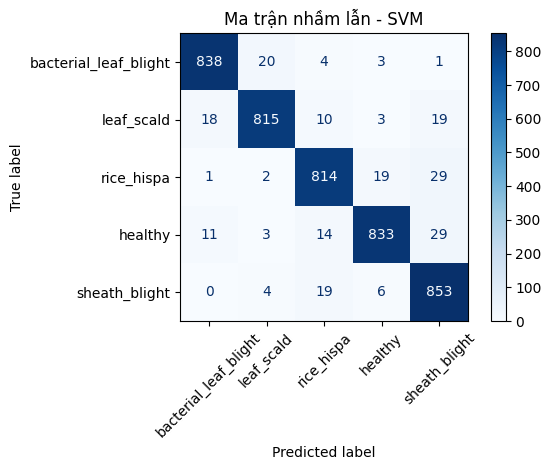

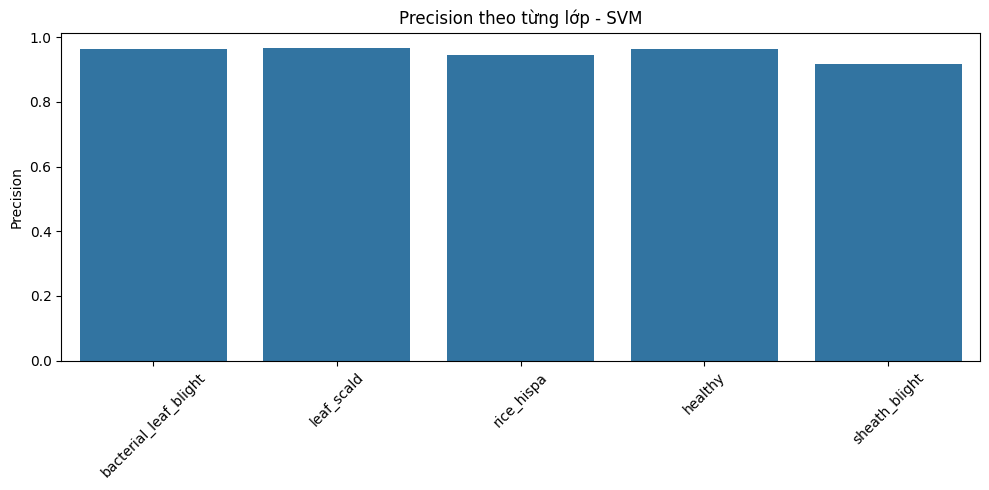

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import learning_curve

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== T·ªïng s·ªë l∆∞·ª£ng m·∫´u ======
print(f"\nS·ªë l∆∞·ª£ng m·∫´u:")
print(f"- Train: {len(X_train)} m·∫´u")
print(f"- Validation: {len(X_val)} m·∫´u")
print(f"- Test: {len(X_test)} m·∫´u")

# ====== In ra s·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp ======
def print_class_distribution(y, split_name):
    print(f"\nS·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p {split_name}:")
    counter = Counter(y)
    for label, count in counter.items():
        class_name = categories[label] if label < len(categories) else f"L·ªõp {label}"
        print(f"  {class_name} ({label}): {count} m·∫´u")

print_class_distribution(y_train, "Train")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

print("\nƒêang hu·∫•n luy·ªán m√¥ h√¨nh SVM...")
svm_model = SVC(kernel='rbf', C=20.0, gamma='scale')
svm_model.fit(X_train, y_train)
'''
svm = SVC()
param_grid = {
    'C': [0.1, 1, 20],
    'kernel':['rbf'],
    'gamma': [0.01, 0.1, 1, 10, 'scale', 'auto']
}
'''
# ====== ƒê√°nh gi√° tr√™n t·∫≠p validation ======
y_val_pred = svm_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
print(f"\n[SVM] Accuracy (val): {val_acc*100:.2f}%")
print(f"[SVM] F1-score (val): {val_f1:.4f}")

# ====== ƒê√°nh gi√° tr√™n t·∫≠p test ======
y_pred = svm_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n[SVM] Accuracy (test): {acc*100:.2f}%")
print(f"[SVM] F1-score (test): {f1:.4f}")
print("\n[SVM] B√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred, target_names=categories))
'''
# ====== L∆∞u m√¥ h√¨nh SVM n·∫øu t·ªët ======
if f1 >= 0.9:
    model_path = os.path.join(DATA_DIR, 'svm_model.pkl')
    joblib.dump(svm_model, model_path)
    print(f"\nƒê√£ l∆∞u m√¥ h√¨nh SVM v·ªõi F1-score: {f1:.4f}")
else:
    print(f"\nF1-score ({f1:.4f}) kh√¥ng ƒë·ªß ng∆∞·ª°ng ƒë·ªÉ l∆∞u m√¥ h√¨nh.")
'''
# ====== V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n cho SVM ======
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma tr·∫≠n nh·∫ßm l·∫´n - SVM")
plt.tight_layout()
plt.show()

# ====== Precision theo l·ªõp (SVM) ======
report = classification_report(y_test, y_pred, target_names=categories, output_dict=True)
precision_values = [report[cat]['precision'] for cat in categories]

plt.figure(figsize=(10, 5))
sns.barplot(x=categories, y=precision_values)
plt.ylabel("Precision")
plt.title("Precision theo t·ª´ng l·ªõp - SVM")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





S·ªë l∆∞·ª£ng m·∫´u:
- Train: 34944 m·∫´u
- Validation: 4368 m·∫´u
- Test: 4368 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Train:
  bacterial_leaf_blight (0): 6932 m·∫´u
  leaf_scald (1): 6916 m·∫´u
  rice_hispa (2): 6916 m·∫´u
  healthy (3): 7124 m·∫´u
  sheath_blight (4): 7056 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Validation:
  bacterial_leaf_blight (0): 867 m·∫´u
  leaf_scald (1): 864 m·∫´u
  rice_hispa (2): 864 m·∫´u
  healthy (3): 891 m·∫´u
  sheath_blight (4): 882 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Test:
  bacterial_leaf_blight (0): 866 m·∫´u
  leaf_scald (1): 865 m·∫´u
  rice_hispa (2): 865 m·∫´u
  healthy (3): 890 m·∫´u
  sheath_blight (4): 882 m·∫´u

‚úÖ M√¥ h√¨nh v√≤ng 1 ƒë√£ t·ªìn t·∫°i. T·∫£i v√† ƒë√°nh gi√° l·∫°i.
   ƒê√£ t·∫£i | Accuracy: 94.94% | F1-score: 0.9495

üí° Ph√°t hi·ªán v√≤ng hu·∫•n luy·ªán ch∆∞a ho√†n th√†nh. B·∫Øt ƒë·∫ßu t·ª´ v√≤ng 2.

üîÅ B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán SVM v√≤ng th·ª© 2:
‚úÖ Test  | Acc

<ipython-input-3-cac791788ed6>:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


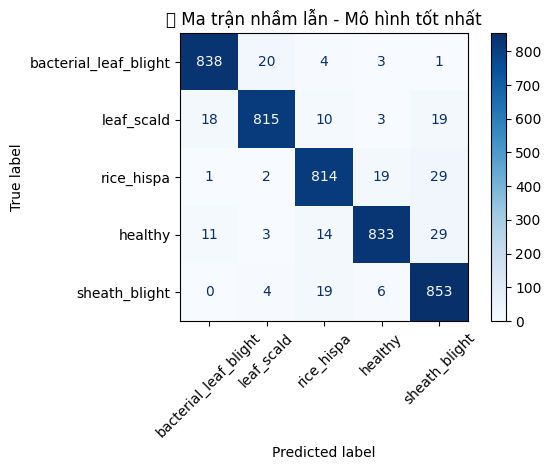

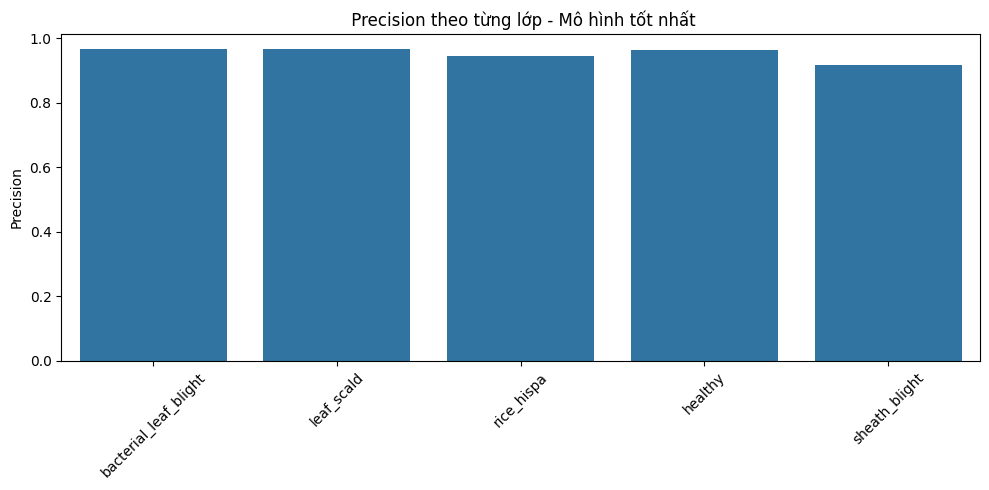


üíæ ƒê√£ l∆∞u m√¥ h√¨nh SVM t·ªët nh·∫•t v·ªõi F1-score: 0.9508 v√†o: /content/drive/MyDrive/Lua _5_4Au_16.4/svm_model_best.pkl


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from statistics import mean, stdev
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import joblib
from collections import Counter # Import Counter

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'
MODEL_SAVE_DIR = os.path.join(DATA_DIR, 'saved_svm_rounds') # Th∆∞ m·ª•c ƒë·ªÉ l∆∞u c√°c m√¥ h√¨nh c·ªßa t·ª´ng v√≤ng
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # T·∫°o th∆∞ m·ª•c n·∫øu ch∆∞a t·ªìn t·∫°i

# T·∫£i d·ªØ li·ªáu ban ƒë·∫ßu (c√≥ th·ªÉ l√† X_train3, y_train3, v.v. nh∆∞ trong code g·ªëc)
# C√°c file n√†y s·∫Ω ƒë∆∞·ª£c t·∫£i l·∫°i trong v√≤ng l·∫∑p cho t·ª´ng round
X_train_initial = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val_initial   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test_initial  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train_initial = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val_initial   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test_initial  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== T·ªïng s·ªë l∆∞·ª£ng m·∫´u (s·ª≠ d·ª•ng d·ªØ li·ªáu ban ƒë·∫ßu ƒë·ªÉ in t·ªïng quan) ======
print(f"\nS·ªë l∆∞·ª£ng m·∫´u:")
print(f"- Train: {len(X_train_initial)} m·∫´u")
print(f"- Validation: {len(X_val_initial)} m·∫´u")
print(f"- Test: {len(X_test_initial)} m·∫´u")

# ====== In ra s·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp ======
def print_class_distribution(y, split_name):
    print(f"\nS·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p {split_name}:")
    counter = Counter(y)
    # S·∫Øp x·∫øp c√°c l·ªõp theo nh√£n ƒë·ªÉ ƒë·∫£m b·∫£o th·ª© t·ª± nh·∫•t qu√°n
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"L·ªõp {label}"
        print(f"  {class_name} ({label}): {count} m·∫´u")

print_class_distribution(y_train_initial, "Train")
print_class_distribution(y_val_initial, "Validation")
print_class_distribution(y_test_initial, "Test")

accuracy_list = []
f1_list = []
best_f1 = -1
best_model = None
best_preds = None
best_y_test = None

num_rounds = 6  # S·ªë l·∫ßn hu·∫•n luy·ªán kh√°c nhau

# X√°c ƒë·ªãnh v√≤ng hu·∫•n luy·ªán b·∫Øt ƒë·∫ßu
start_round = 1
# Ki·ªÉm tra c√°c m√¥ h√¨nh ƒë√£ l∆∞u ƒë·ªÉ t√¨m v√≤ng ch∆∞a ho√†n th√†nh
for i in range(1, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')
    if not os.path.exists(model_path_round):
        start_round = i
        print(f"\nüí° Ph√°t hi·ªán v√≤ng hu·∫•n luy·ªán ch∆∞a ho√†n th√†nh. B·∫Øt ƒë·∫ßu t·ª´ v√≤ng {start_round}.")
        break
    else:
        print(f"\n‚úÖ M√¥ h√¨nh v√≤ng {i} ƒë√£ t·ªìn t·∫°i. T·∫£i v√† ƒë√°nh gi√° l·∫°i.")
        # T·∫£i d·ªØ li·ªáu cho v√≤ng n√†y ƒë·ªÉ ƒë√°nh gi√° l·∫°i
        X_test_round = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))
        y_test_round = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

        loaded_model = joblib.load(model_path_round)
        y_pred_test_loaded = loaded_model.predict(X_test_round)
        acc_test_loaded = accuracy_score(y_test_round, y_pred_test_loaded)
        f1_test_loaded = f1_score(y_test_round, y_pred_test_loaded, average='weighted')

        accuracy_list.append(acc_test_loaded)
        f1_list.append(f1_test_loaded)

        print(f"   ƒê√£ t·∫£i | Accuracy: {acc_test_loaded*100:.2f}% | F1-score: {f1_test_loaded:.4f}")

        # C·∫≠p nh·∫≠t m√¥ h√¨nh t·ªët nh·∫•t t·ª´ c√°c m√¥ h√¨nh ƒë√£ t·∫£i
        if f1_test_loaded > best_f1:
            best_f1 = f1_test_loaded
            best_model = loaded_model
            best_preds = y_pred_test_loaded
            best_y_test = y_test_round

# B·∫Øt ƒë·∫ßu v√≤ng l·∫∑p hu·∫•n luy·ªán t·ª´ v√≤ng ƒë√£ x√°c ƒë·ªãnh
for i in range(start_round, num_rounds + 1):
    model_path_round = os.path.join(MODEL_SAVE_DIR, f'svm_model_round_{i}.pkl')

    # N·∫øu m√¥ h√¨nh cho v√≤ng n√†y ƒë√£ t·ªìn t·∫°i, b·ªè qua hu·∫•n luy·ªán
    if os.path.exists(model_path_round):
        print(f"\nüîÑ V√≤ng hu·∫•n luy·ªán SVM th·ª© {i} ƒë√£ ho√†n th√†nh tr∆∞·ªõc ƒë√≥. B·ªè qua hu·∫•n luy·ªán l·∫°i.")
        # D·ªØ li·ªáu v√† k·∫øt qu·∫£ ƒë√£ ƒë∆∞·ª£c x·ª≠ l√Ω ·ªü b∆∞·ªõc ki·ªÉm tra tr∆∞·ªõc v√≤ng l·∫∑p
        continue

    print(f"\nüîÅ B·∫Øt ƒë·∫ßu hu·∫•n luy·ªán SVM v√≤ng th·ª© {i}:")

    # T·∫£i d·ªØ li·ªáu cho v√≤ng hi·ªán t·∫°i
    X_train = np.load(os.path.join(DATA_DIR, f'X_train{i}.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, f'X_val{i}.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, f'X_test{i}.npy'))

    y_train = np.load(os.path.join(DATA_DIR, f'y_train{i}.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, f'y_val{i}.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, f'y_test{i}.npy'))

    # Kh·ªüi t·∫°o v√† hu·∫•n luy·ªán m√¥ h√¨nh
    model = SVC(kernel='rbf', C=20.0, gamma='scale')
    model.fit(X_train, y_train)

    # D·ª± ƒëo√°n tr√™n test set
    y_pred_test = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # D·ª± ƒëo√°n tr√™n validation set
    y_pred_val = model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    f1_val = f1_score(y_val, y_pred_val, average='weighted')

    accuracy_list.append(acc_test)
    f1_list.append(f1_test)

    print(f"‚úÖ Test  | Accuracy: {acc_test*100:.2f}% | F1-score: {f1_test:.4f}")
    print(f"üìä Val   | Accuracy: {acc_val*100:.2f}% | F1-score: {f1_val:.4f}")

    # C·∫≠p nh·∫≠t m√¥ h√¨nh t·ªët nh·∫•t
    if f1_test > best_f1:
        best_f1 = f1_test
        best_model = model
        best_preds = y_pred_test
        best_y_test = y_test

    # L∆∞u m√¥ h√¨nh c·ªßa v√≤ng hi·ªán t·∫°i
    joblib.dump(model, model_path_round)
    print(f"üíæ ƒê√£ l∆∞u m√¥ h√¨nh v√≤ng {i} v√†o: {model_path_round}")


# ==== T·ªïng k·∫øt ====
print("\n K·∫øt qu·∫£ t·ªïng h·ª£p:")
if accuracy_list: # ƒê·∫£m b·∫£o danh s√°ch kh√¥ng r·ªóng tr∆∞·ªõc khi t√≠nh to√°n
    print(f"- Accuracy trung b√¨nh: {mean(accuracy_list)*100:.2f}%")
    print(f"- Accuracy std       : {stdev(accuracy_list)*100:.2f}")
    print(f"- F1-score trung b√¨nh: {mean(f1_list):.4f}")
    print(f"- F1-score std       : {stdev(f1_list):.4f}")
else:
    print("- Kh√¥ng c√≥ k·∫øt qu·∫£ n√†o ƒë∆∞·ª£c ghi nh·∫≠n.")

# ==== In k·∫øt qu·∫£ m√¥ h√¨nh t·ªët nh·∫•t ====
if best_model:
    print("\nüèÜ M√¥ h√¨nh c√≥ F1-score cao nh·∫•t:")
    print(f"- F1-score: {best_f1:.4f}")
    print(classification_report(best_y_test, best_preds, target_names=categories))

    # ==== V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n ====
    cm = confusion_matrix(best_y_test, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("üèÜ Ma tr·∫≠n nh·∫ßm l·∫´n - M√¥ h√¨nh t·ªët nh·∫•t")
    plt.tight_layout()
    plt.show()

    # ==== V·∫Ω bi·ªÉu ƒë·ªì precision theo t·ª´ng l·ªõp ====
    report = classification_report(best_y_test, best_preds, target_names=categories, output_dict=True)
    precision_values = [report[cat]['precision'] for cat in categories]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values)
    plt.ylabel("Precision")
    plt.title(" Precision theo t·ª´ng l·ªõp - M√¥ h√¨nh t·ªët nh·∫•t")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ==== L∆∞u m√¥ h√¨nh t·ªët nh·∫•t (n·∫øu ch∆∞a ƒë∆∞·ª£c l∆∞u) ====
    # M√¥ h√¨nh t·ªët nh·∫•t c√≥ th·ªÉ l√† m·ªôt trong c√°c m√¥ h√¨nh ƒë√£ ƒë∆∞·ª£c l∆∞u ·ªü tr√™n
    # N·∫øu b·∫°n mu·ªën l∆∞u m·ªôt b·∫£n sao ri√™ng bi·ªát c·ªßa m√¥ h√¨nh t·ªët nh·∫•t, h√£y l√†m nh∆∞ sau:
    model_best_path = os.path.join(DATA_DIR, 'svm_model_best.pkl')
    joblib.dump(best_model, model_best_path)
    print(f"\nüíæ ƒê√£ l∆∞u m√¥ h√¨nh SVM t·ªët nh·∫•t v·ªõi F1-score: {best_f1:.4f} v√†o: {model_best_path}")
else:
    print("\n‚ö†Ô∏è Kh√¥ng t√¨m th·∫•y m√¥ h√¨nh t·ªët nh·∫•t (c√≥ th·ªÉ do kh√¥ng c√≥ v√≤ng hu·∫•n luy·ªán n√†o ho√†n th√†nh).")




ƒêang hu·∫•n luy·ªán m√¥ h√¨nh Random Forest...

[Random Forest] Accuracy (val): 85.60%
[Random Forest] F1-score (val): 0.8590

[Random Forest] Accuracy (test): 87.71%
[Random Forest] F1-score (test): 0.8790

[Random Forest] B√°o c√°o ph√¢n lo·∫°i:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.97      0.90      0.93       866
           leaf_scald       0.93      0.87      0.90       865
           rice_hispa       0.78      0.87      0.82       865
              healthy       0.97      0.83      0.89       890
        sheath_blight       0.78      0.92      0.84       882

             accuracy                           0.88      4368
            macro avg       0.89      0.88      0.88      4368
         weighted avg       0.89      0.88      0.88      4368



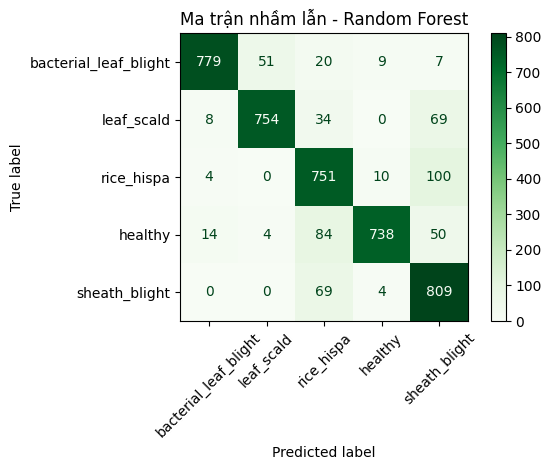

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import learning_curve

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
# ====== Hu·∫•n luy·ªán m√¥ h√¨nh Random Forest ======
print("\nƒêang hu·∫•n luy·ªán m√¥ h√¨nh Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# ====== ƒê√°nh gi√° tr√™n t·∫≠p validation ======
y_val_pred_rf = rf_model.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf, average='weighted')
print(f"\n[Random Forest] Accuracy (val): {val_acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (val): {val_f1_rf:.4f}")

# ====== ƒê√°nh gi√° tr√™n t·∫≠p test ======
y_pred_rf = rf_model.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n[Random Forest] Accuracy (test): {acc_rf*100:.2f}%")
print(f"[Random Forest] F1-score (test): {f1_rf:.4f}")
print("\n[Random Forest] B√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred_rf, target_names=categories))

# ====== V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n cho Random Forest ======
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=categories)
disp_rf.plot(cmap="Greens", xticks_rotation=45)
plt.title("Ma tr·∫≠n nh·∫ßm l·∫´n - Random Forest")
plt.tight_layout()
plt.show()


ƒê√£ t·∫£i d·ªØ li·ªáu t·ª´ X_train3.npy v√† c√°c file li√™n quan.

S·ªë l∆∞·ª£ng m·∫´u ƒë√£ t·∫£i:
- Train: 34944 m·∫´u
- Validation: 4368 m·∫´u
- Test: 4368 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Train:
   - bacterial_leaf_blight (0): 6932 m·∫´u
   - leaf_scald (1): 6916 m·∫´u
   - rice_hispa (2): 6916 m·∫´u
   - healthy (3): 7124 m·∫´u
   - sheath_blight (4): 7056 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Validation:
   - bacterial_leaf_blight (0): 867 m·∫´u
   - leaf_scald (1): 864 m·∫´u
   - rice_hispa (2): 864 m·∫´u
   - healthy (3): 891 m·∫´u
   - sheath_blight (4): 882 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Test:
   - bacterial_leaf_blight (0): 866 m·∫´u
   - leaf_scald (1): 865 m·∫´u
   - rice_hispa (2): 865 m·∫´u
   - healthy (3): 890 m·∫´u
   - sheath_blight (4): 882 m·∫´u

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh K-Nearest Neighbors...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

C√°c si√™u tham s·ªë t·ªët nh·∫•t cho K

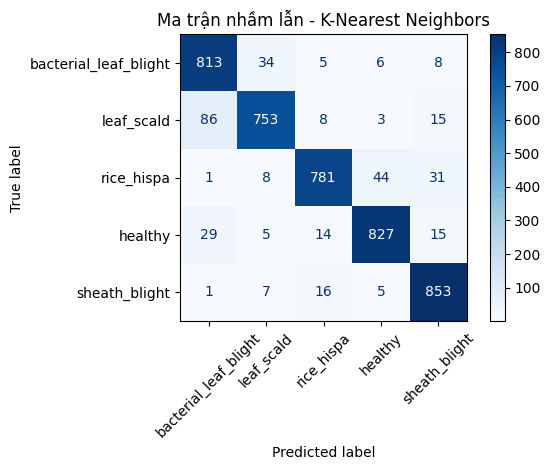

<ipython-input-3-2514ddbb3496>:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=precision_values_knn, palette='viridis')


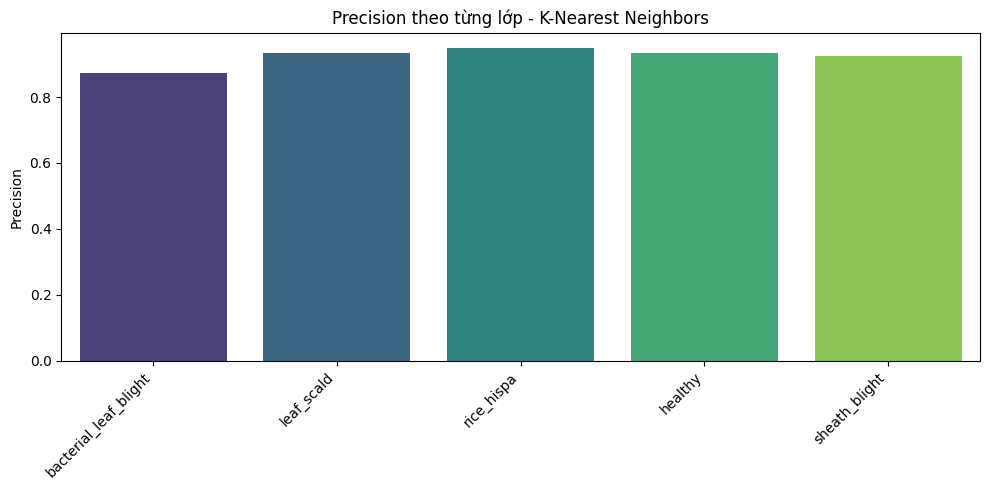

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import joblib # Kh√¥ng c·∫ßn import joblib n·∫øu kh√¥ng l∆∞u m√¥ h√¨nh
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n v√† th√¥ng tin ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'
# MODEL_SAVE_PATH_KNN = os.path.join(DATA_DIR, 'knn_model_best.pkl') # Kh√¥ng c·∫ßn bi·∫øn n√†y n·∫øu kh√¥ng l∆∞u m√¥ h√¨nh

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== H√†m in ph√¢n ph·ªëi l·ªõp (t√°i s·ª≠ d·ª•ng) ======
def print_class_distribution(y, split_name, categories):
    print(f"\nS·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p {split_name}:")
    counter = Counter(y)
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"L·ªõp {label} (Ch∆∞a x√°c ƒë·ªãnh)"
        print(f"   - {class_name} ({label}): {count} m·∫´u")

# ====== T·∫£i v√† ki·ªÉm tra d·ªØ li·ªáu ======
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))
    print("ƒê√£ t·∫£i d·ªØ li·ªáu t·ª´ X_train3.npy v√† c√°c file li√™n quan.")
except FileNotFoundError:
    print(f"L·ªói: Kh√¥ng t√¨m th·∫•y c√°c file d·ªØ li·ªáu t·∫°i {DATA_DIR}. Vui l√≤ng ki·ªÉm tra l·∫°i ƒë∆∞·ªùng d·∫´n v√† t√™n file.")
    exit()

# T·ªïng s·ªë l∆∞·ª£ng m·∫´u
print(f"\nS·ªë l∆∞·ª£ng m·∫´u ƒë√£ t·∫£i:")
print(f"- Train: {len(X_train)} m·∫´u")
print(f"- Validation: {len(X_val)} m·∫´u")
print(f"- Test: {len(X_test)} m·∫´u")

# In ra s·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp
print_class_distribution(y_train, "Train", categories)
print_class_distribution(y_val, "Validation", categories)
print_class_distribution(y_test, "Test", categories)

# K·∫øt h·ª£p t·∫≠p hu·∫•n luy·ªán v√† validation cho GridSearchCV
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

# ====== Hu·∫•n luy·ªán m√¥ h√¨nh K-Nearest Neighbors ======
print("\nƒêang hu·∫•n luy·ªán m√¥ h√¨nh K-Nearest Neighbors...")

# ƒê·ªãnh nghƒ©a c√°c tham s·ªë m√† b·∫°n mu·ªën th·ª≠ cho KNN
param_grid_knn = {
    'n_neighbors': [5],
    'weights': ['distance'],
    'p': [2]
}

# T·∫°o m√¥ h√¨nh KNeighborsClassifier c∆° b·∫£n
knn_base = KNeighborsClassifier()

# Kh·ªüi t·∫°o GridSearchCV ƒë·ªÉ t√¨m ki·∫øm si√™u tham s·ªë t·ªët nh·∫•t
grid_search_knn = GridSearchCV(estimator=knn_base, param_grid=param_grid_knn,
                               cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

grid_search_knn.fit(X_train_combined, y_train_combined)

print(f"\nC√°c si√™u tham s·ªë t·ªët nh·∫•t cho KNN: {grid_search_knn.best_params_}")
print(f"F1-score t·ªët nh·∫•t tr√™n t·∫≠p hu·∫•n luy·ªán (GridSearchCV) cho KNN: {grid_search_knn.best_score_:.4f}")

# L·∫•y m√¥ h√¨nh KNN t·ªët nh·∫•t t·ª´ GridSearchCV
best_knn_model = grid_search_knn.best_estimator_
print("\nƒê√£ t√¨m th·∫•y m√¥ h√¨nh K-Nearest Neighbors t·ªët nh·∫•t.")

# ====== ƒê√°nh gi√° tr√™n t·∫≠p test v·ªõi m√¥ h√¨nh KNN t·ªët nh·∫•t ======
print("\nƒê√°nh gi√° m√¥ h√¨nh K-Nearest Neighbors t·ªët nh·∫•t tr√™n t·∫≠p test...")
y_pred_knn = best_knn_model.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\n[K-Nearest Neighbors] Accuracy (test): {acc_knn*100:.2f}%")
print(f"[K-Nearest Neighbors] F1-score (test): {f1_knn:.4f}")
print("\n[K-Nearest Neighbors] B√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred_knn, target_names=categories))

# ====== V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n cho K-Nearest Neighbors ======
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=categories)
disp_knn.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma tr·∫≠n nh·∫ßm l·∫´n - K-Nearest Neighbors")
plt.tight_layout()
plt.show()

# ====== V·∫Ω bi·ªÉu ƒë·ªì precision theo t·ª´ng l·ªõp cho K-Nearest Neighbors ======
report_knn = classification_report(y_test, y_pred_knn, target_names=categories, output_dict=True)
precision_values_knn = [report_knn[cat]['precision'] for cat in categories if cat in report_knn]

if len(precision_values_knn) == len(categories):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_knn, palette='viridis')
    plt.ylabel("Precision")
    plt.title("Precision theo t·ª´ng l·ªõp - K-Nearest Neighbors")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("C·∫£nh b√°o: Kh√¥ng th·ªÉ v·∫Ω bi·ªÉu ƒë·ªì Precision cho KNN do s·ªë l∆∞·ª£ng l·ªõp kh√¥ng kh·ªõp.")


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import GridSearchCV
# Thay th·∫ø KNeighborsClassifier b·∫±ng LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n v√† th√¥ng tin ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]

# ====== H√†m in ph√¢n ph·ªëi l·ªõp (t√°i s·ª≠ d·ª•ng) ======
def print_class_distribution(y, split_name, categories):
    print(f"\nS·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p {split_name}:")
    counter = Counter(y)
    sorted_labels = sorted(counter.keys())
    for label in sorted_labels:
        count = counter[label]
        class_name = categories[label] if label < len(categories) else f"L·ªõp {label} (Ch∆∞a x√°c ƒë·ªãnh)"
        print(f"   - {class_name} ({label}): {count} m·∫´u")

# ====== T·∫£i v√† ki·ªÉm tra d·ªØ li·ªáu ======
try:
    X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
    X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
    X_test  = np.load(os.path.join(DATA_DIR, 'X_test3.npy'))
    y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
    y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
    y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))
    print("ƒê√£ t·∫£i d·ªØ li·ªáu t·ª´ X_train3.npy v√† c√°c file li√™n quan.")
except FileNotFoundError:
    print(f"L·ªói: Kh√¥ng t√¨m th·∫•y c√°c file d·ªØ li·ªáu t·∫°i {DATA_DIR}. Vui l√≤ng ki·ªÉm tra l·∫°i ƒë∆∞·ªùng d·∫´n v√† t√™n file.")
    exit()

# T·ªïng s·ªë l∆∞·ª£ng m·∫´u
print(f"\nS·ªë l∆∞·ª£ng m·∫´u ƒë√£ t·∫£i:")
print(f"- Train: {len(X_train)} m·∫´u")
print(f"- Validation: {len(X_val)} m·∫´u")
print(f"- Test: {len(X_test)} m·∫´u")

# In ra s·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp
print_class_distribution(y_train, "Train", categories)
print_class_distribution(y_val, "Validation", categories)
print_class_distribution(y_test, "Test", categories)

# K·∫øt h·ª£p t·∫≠p hu·∫•n luy·ªán v√† validation cho GridSearchCV
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.concatenate((y_train, y_val))

# ====== Hu·∫•n luy·ªán m√¥ h√¨nh Logistic Regression ======
print("\nƒêang hu·∫•n luy·ªán m√¥ h√¨nh Logistic Regression...")
param_grid_lr = {
    'C': [0.1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'lbfgs'], # 'liblinear' t·ªët cho t·∫≠p nh·ªè, 'lbfgs' cho t·∫≠p l·ªõn
    'multi_class': ['auto'], # 'auto' ƒë·ªÉ t·ª± ƒë·ªông ch·ªçn 'ovr' ho·∫∑c 'multinomial'
    'max_iter': [1000] # TƒÉng s·ªë l·∫ßn l·∫∑p t·ªëi ƒëa ƒë·ªÉ ƒë·∫£m b·∫£o h·ªôi t·ª•
}

lr_base = LogisticRegression(random_state=42, n_jobs=-1)

# Kh·ªüi t·∫°o GridSearchCV ƒë·ªÉ t√¨m ki·∫øm si√™u tham s·ªë t·ªët nh·∫•t
grid_search_lr = GridSearchCV(estimator=lr_base, param_grid=param_grid_lr,
                               cv=5, scoring='f1_weighted', verbose=2, n_jobs=-1)

grid_search_lr.fit(X_train_combined, y_train_combined)

print(f"\nC√°c si√™u tham s·ªë t·ªët nh·∫•t cho Logistic Regression: {grid_search_lr.best_params_}")
print(f"F1-score t·ªët nh·∫•t tr√™n t·∫≠p hu·∫•n luy·ªán (GridSearchCV) cho Logistic Regression: {grid_search_lr.best_score_:.4f}")

# L·∫•y m√¥ h√¨nh Logistic Regression t·ªët nh·∫•t t·ª´ GridSearchCV
best_lr_model = grid_search_lr.best_estimator_
print("\nƒê√£ t√¨m th·∫•y m√¥ h√¨nh Logistic Regression t·ªët nh·∫•t.")

# ====== ƒê√°nh gi√° tr√™n t·∫≠p test v·ªõi m√¥ h√¨nh Logistic Regression t·ªët nh·∫•t ======
print("\nƒê√°nh gi√° m√¥ h√¨nh Logistic Regression t·ªët nh·∫•t tr√™n t·∫≠p test...")
y_pred_lr = best_lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"\n[Logistic Regression] Accuracy (test): {acc_lr*100:.2f}%")
print(f"[Logistic Regression] F1-score (test): {f1_lr:.4f}")
print("\n[Logistic Regression] B√°o c√°o ph√¢n lo·∫°i:")
print(classification_report(y_test, y_pred_lr, target_names=categories))

# ====== V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n cho Logistic Regression ======
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=categories)
disp_lr.plot(cmap="Blues", xticks_rotation=45)
plt.title("Ma tr·∫≠n nh·∫ßm l·∫´n - Logistic Regression")
plt.tight_layout()
plt.show()

# ====== V·∫Ω bi·ªÉu ƒë·ªì precision theo t·ª´ng l·ªõp cho Logistic Regression ======
report_lr = classification_report(y_test, y_pred_lr, target_names=categories, output_dict=True)
# L·ªçc c√°c danh m·ª•c c√≥ trong b√°o c√°o ƒë·ªÉ tr√°nh l·ªói n·∫øu m·ªôt l·ªõp kh√¥ng c√≥ m·∫´u n√†o trong y_test
precision_values_lr = [report_lr[cat]['precision'] for cat in categories if cat in report_lr and 'precision' in report_lr[cat]]

# Ki·ªÉm tra l·∫°i s·ªë l∆∞·ª£ng gi√° tr·ªã precision c√≥ ƒë∆∞·ª£c so v·ªõi s·ªë l∆∞·ª£ng danh m·ª•c
if len(precision_values_lr) == len(categories):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=categories, y=precision_values_lr, palette='viridis')
    plt.ylabel("Precision")
    plt.title("Precision theo t·ª´ng l·ªõp - Logistic Regression")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("C·∫£nh b√°o: Kh√¥ng th·ªÉ v·∫Ω bi·ªÉu ƒë·ªì Precision cho Logistic Regression do s·ªë l∆∞·ª£ng l·ªõp kh√¥ng kh·ªõp ho·∫∑c thi·∫øu d·ªØ li·ªáu.")

ƒê√£ t·∫£i d·ªØ li·ªáu t·ª´ X_train3.npy v√† c√°c file li√™n quan.

S·ªë l∆∞·ª£ng m·∫´u ƒë√£ t·∫£i:
- Train: 34944 m·∫´u
- Validation: 4368 m·∫´u
- Test: 4368 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Train:
   - bacterial_leaf_blight (0): 6932 m·∫´u
   - leaf_scald (1): 6916 m·∫´u
   - rice_hispa (2): 6916 m·∫´u
   - healthy (3): 7124 m·∫´u
   - sheath_blight (4): 7056 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Validation:
   - bacterial_leaf_blight (0): 867 m·∫´u
   - leaf_scald (1): 864 m·∫´u
   - rice_hispa (2): 864 m·∫´u
   - healthy (3): 891 m·∫´u
   - sheath_blight (4): 882 m·∫´u

S·ªë l∆∞·ª£ng m·∫´u theo t·ª´ng l·ªõp trong t·∫≠p Test:
   - bacterial_leaf_blight (0): 866 m·∫´u
   - leaf_scald (1): 865 m·∫´u
   - rice_hispa (2): 865 m·∫´u
   - healthy (3): 890 m·∫´u
   - sheath_blight (4): 882 m·∫´u

ƒêang hu·∫•n luy·ªán m√¥ h√¨nh Logistic Regression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import learning_curve

# ====== C·∫•u h√¨nh ƒë∆∞·ªùng d·∫´n ======
DATA_DIR = '/content/drive/MyDrive/Lua _5_4Au_16.4'

X_train = np.load(os.path.join(DATA_DIR, 'X_train3.npy'))
X_val   = np.load(os.path.join(DATA_DIR, 'X_val3.npy'))
X_test  = np.load(os.path.join(DATA_DIR, 'X_test.npy'))

y_train = np.load(os.path.join(DATA_DIR, 'y_train3.npy'))
y_val   = np.load(os.path.join(DATA_DIR, 'y_val3.npy'))
y_test  = np.load(os.path.join(DATA_DIR, 'y_test3.npy'))

categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
svm = SVC()
param_grid = {
    'C': [ 20],
    'kernel':[ 'rbf'],
    'gamma': [0.01, 0.1]
}
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best score: {best_score}")
print(f"Best parameters: {best_params}")

In [ ]:
import os
import cv2
import joblib
from skimage.feature import hog
categories = [
    'bacterial_leaf_blight',
    'leaf_scald',
    'rice_hispa',
    'healthy',
    'sheath_blight'
]
def predict_image(image_path, model, scaler):
    # Ki·ªÉm tra ƒë∆∞·ªùng d·∫´n ·∫£nh
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Kh√¥ng t√¨m th·∫•y file: {image_path}")

    print(f"ƒêang x·ª≠ l√Ω ·∫£nh: {image_path}")

    # ƒê·ªçc v√† x·ª≠ l√Ω ·∫£nh
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"L·ªói khi ƒë·ªçc ·∫£nh (cv2.imread tr·∫£ v·ªÅ None): {image_path}")

    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Tr√≠ch xu·∫•t HOG
    hog_feature = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(4, 4), feature_vector=True)

    # Chu·∫©n h√≥a
    hog_feature = scaler.transform([hog_feature])

  # D·ª± ƒëo√°n x√°c su·∫•t
    probabilities = model.predict_proba(hog_feature)[0]

    # In ra t·ª´ng l·ªõp v·ªõi % t∆∞∆°ng ·ª©ng
    for i, prob in enumerate(probabilities):
        print(f"{categories[i]}: {prob*100:.2f}%")

    # Tr·∫£ v·ªÅ nh√£n c√≥ x√°c su·∫•t cao nh·∫•t
    prediction = model.predict(hog_feature)
    return prediction[0]

# Load model v√† scaler
model_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/svm_model.pkl"
scaler_path = "/content/drive/MyDrive/Lua _5_4Au_16.4/scaler.pkl"

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Kh√¥ng t√¨m th·∫•y m√¥ h√¨nh: {model_path}")
if not os.path.exists(scaler_path):
    raise FileNotFoundError(f"Kh√¥ng t√¨m th·∫•y scaler: {scaler_path}")

svm_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Test v·ªõi m·ªôt ·∫£nh m·ªõi
image_path = "/content/drive/MyDrive/DATASET/Test_Model/healthy2.jpg"
label = predict_image(image_path, svm_model, scaler)
print(f"·∫¢nh n√†y thu·ªôc l·ªõp: {categories[label]}")


ƒêang x·ª≠ l√Ω ·∫£nh: /content/drive/MyDrive/DATASET/Test_Model/healthy2.jpg


AttributeError: This 'SVC' has no attribute 'predict_proba'